In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

In [3]:
data_dir = 'data_log'
subjects = ['R2280', 'R2490', 'R2487', 'R2488']

# Initialize an empty list to store DataFrames
dataframes = []

for subj in subjects:
    data_log_dir = f"{data_dir}/{subj}"
    json_files = glob.glob(os.path.join(data_log_dir, '*.json'))

    for json_file in json_files:
        try:
            with open(json_file, 'r') as file:
                print(json_file)
                data = json.load(file)
                trial_data = data['trial_data']
                loc_data = data['locolizer_data']
            df = pd.json_normalize(loc_data)
            df['subj'] = subj  # Add subject number as a new column
            dataframes.append(df)
        except json.JSONDecodeError as e:
            print(f"Error reading file {json_file}: {e}")

    loc_file_path = f"{data_dir}/{subj}/{subj}_loc.json"
    exp_file_path = f"{data_dir}/{subj}/{subj}_exp.json"
    
    if os.path.exists(loc_file_path):
        data = json.load(open(loc_file_path, 'r'))
        loc_data = data['locolizer_data']
    elif os.path.exists(exp_file_path):
        data_exp = json.load(open(exp_file_path, 'r'))
        loc_data = data_exp['locolizer_data']
    else:
        print(f"No loc or exp file found for subject {subj}")
        continue

    df = pd.json_normalize(loc_data)
    df['subj'] = subj  # Add subject number as a new column
    dataframes.append(df)


# Combine all DataFrames if any exist
if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
else:
    print("No valid JSON files found.")

data_log/R2280/R2280_loc.json
data_log/R2280/R2280_exp.json
data_log/R2490/R2490.json
No loc or exp file found for subject R2490
data_log/R2487/R2487.json
No loc or exp file found for subject R2487
data_log/R2488/R2488_exp.json
data_log/R2488/R2488_loc.json


In [4]:
print(combined_data.head())

                                              events locolizer.rule  \
0  [{'time': 12.828553050290793, 'event': 'start'...           tree   
1  [{'time': 17.76303712790832, 'event': 'start'}...          chain   
2  [{'time': 22.71588610811159, 'event': 'start'}...           loop   
3  [{'time': 27.666120220907032, 'event': 'start'...           tree   
4  [{'time': 32.6146788992919, 'event': 'start'},...           loop   

                                      locolizer.grid  locolizer.score  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....              1.0   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....              1.0   
2  [[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0], [0.0, 0....              1.0   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....              1.0   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....              1.0   

  locolizer.final_choice                                    locolizer.start  \
0                      0  [[2, 2], [2, 3], [2, 4], [2, 

In [6]:
def calculate_total_time(events):
    start_time = None
    done_time = None
    timeout = False
    for event in events:
        if event['event'] == 'start':
            start_time = event['time']
        elif event['event'] == 'done':
            done_time = event['time']
            break
        elif event['event'] == 'timeout':
            done_time = event['time']
            timeout = True
            break
    
    if start_time is not None and done_time is not None:
        return done_time - start_time, timeout
    else:
        return 0, timeout  # Return 0 and timeout status if times are not found

def calculate_choice(events):
    num_choice = 0
    final_choice = 0  # Default to 0 if no final choice is found
    for event in events:
        if event['event'] == 'choice':
            num_choice += 1
            final_choice = event['choice'] if event['choice'] is not None else 0
            final_choice = int(final_choice)
    return num_choice, final_choice

def calculate_choice_time(events):
    start_time = None
    choice_time = None
    for event in events:
        if event['event'] == 'done':
            start_time = event['time'] -3.4
        if event['event'] == 'choice':
            choice_time = event['time']
    
    if start_time is None or choice_time is None:
        return 3.0
    return choice_time - start_time

def loc_start(locolizer):
    # Extract the rule directly from the dictionary
    rule = locolizer.get('rule', None)
    # Count the number of 'start' events
    num_start = len(locolizer.get('start', []))
    
    # Count how many 'start' indices in the grid are equal to 1
    grid = locolizer.get('grid', [])
    start_positions = locolizer.get('start', [])
    
    # Ensure indices are within bounds
    num_red = sum(1 for x, y in start_positions if 0 <= x < len(grid) and 0 <= y < len(grid[x]) and grid[x][y] == 1)
    
    return rule, num_start, num_red

In [7]:

results = []
for _, trial in combined_data.iterrows():  # Use iterrows() to iterate over DataFrame rows
    correct = 0
    events = trial['events']
    rule_index = {'None':0,'tree':1,'loop':2,'chain':3}
    
    # Calculate metrics
    total_time, timeout = calculate_total_time(events)
    num_choice, final_choice = calculate_choice(events)
    choice_time = calculate_choice_time(events)
    
    # Access locolizer data using the correct keys
    rule = trial.get('locolizer.rule', None)
    num_start = len(trial.get('locolizer.start', []))
    grid = trial.get('locolizer.grid', [])
    
    # Count how many 'start' indices in the grid are equal to 1
    start_positions = trial.get('locolizer.start', [])
    num_red = sum(1 for x, y in start_positions if 0 <= x < len(grid) and 0 <= y < len(grid[x]) and grid[x][y] == 1)
    
    rule = rule_index.get(rule)
    ac = 1 if final_choice == rule else 0
    
    # Append results for this trial
    results.append({
        'trial_index': trial['locolizer.trial_index'],
        't': total_time,
        'num_choice': num_choice,
        'final_choice': final_choice,
        'choice_time': choice_time,
        'rule': rule,
        'num_start': num_start,
        'num_red': num_red,
        'correct': ac
    })

# Create a DataFrame from the results
loc_df = pd.DataFrame(results)


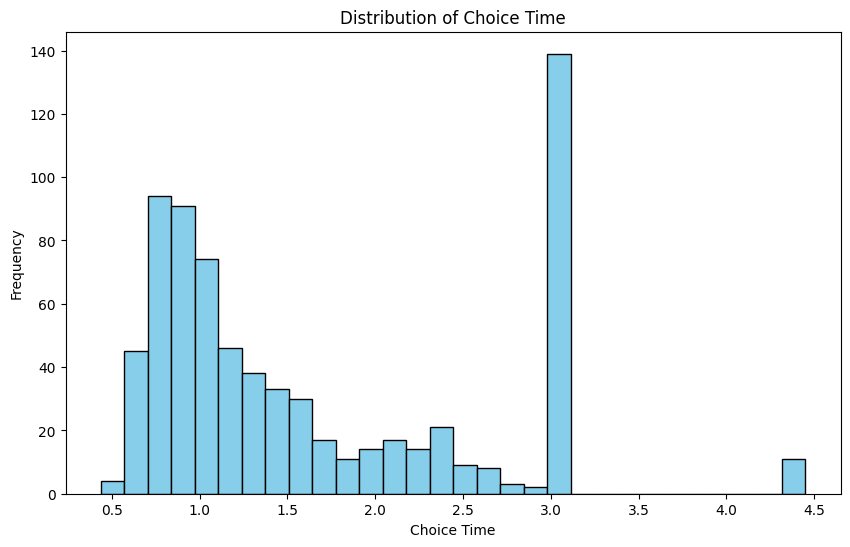

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(loc_df['choice_time'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Choice Time')
plt.ylabel('Frequency')
plt.title('Distribution of Choice Time')

# Show the plot
plt.show()

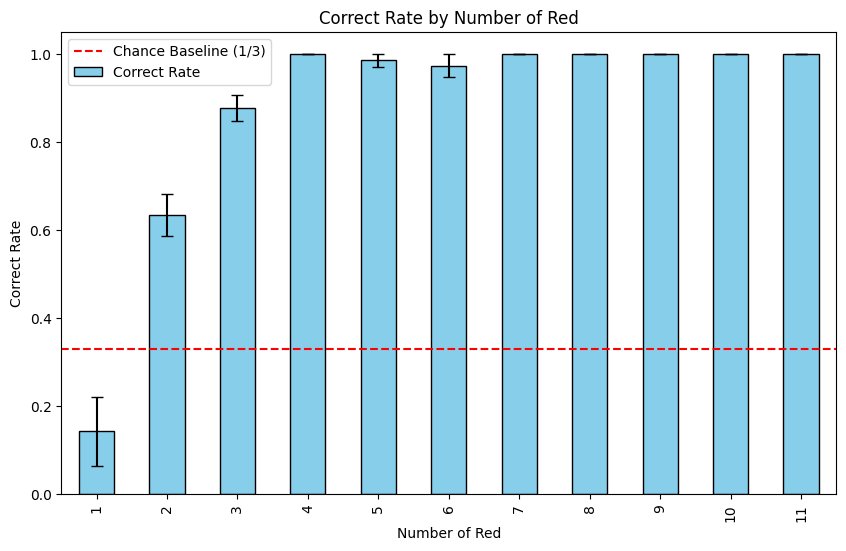

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming loc_df is your DataFrame containing the results
# Filter out trials where final_choice == 0
filtered_df = loc_df[loc_df['final_choice'] != 0]

# Calculate the correct rate and standard error for each num_red
grouped = filtered_df.groupby('num_red')['correct']
correct_rate = grouped.mean()
sem = grouped.sem()  # Standard error of the mean

# Plot the correct rate with error bars
plt.figure(figsize=(10, 6))
correct_rate.plot(kind='bar', yerr=sem, color='skyblue', capsize=4, label='Correct Rate', edgecolor='black')

# Add a horizontal line for the chance baseline at 1/3
plt.axhline(0.33, color='red', linestyle='--', label='Chance Baseline (1/3)')

# Add labels and title
plt.xlabel('Number of Red')
plt.ylabel('Correct Rate')
plt.title('Correct Rate by Number of Red')
plt.legend()

# Show the plot
plt.show()

In [32]:
grouped_stats = loc_df.groupby('num_red')['correct'].agg(['mean', 'var', 'count'])

# Print the statistics
print(grouped_stats)

             mean       var  count
num_red                           
1        0.083333  0.083333     12
2        0.583333  0.253623     24
3        0.875000  0.114130     24
4        0.947368  0.052632     19
5        0.769231  0.192308     13
6        1.000000  0.000000      6
7        1.000000  0.000000      9
8        1.000000  0.000000      9
10       1.000000  0.000000      5
